In [1]:
!apt-get update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [53.9 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:11 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:13 https://developer.download.nvi

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz

In [5]:
!tar xf spark-3.1.1-bin-hadoop2.7.tgz

In [6]:
!pip install -q findspark

In [7]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

In [8]:
import findspark
findspark.init()

In [9]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Collision")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [10]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -y ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels

--2021-05-05 14:13:23--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.203.109.182, 54.164.22.162, 3.211.204.50, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.203.109.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  6.56MB/s    in 2.0s    

2021-05-05 14:13:26 (6.56 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

UnZip 6.00 of 20 April 2009, by Debian. Original by Info-ZIP.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
  file[.zip] may be a wildcard.  -Z => ZipInfo mode ("unzip -Z" for usage).

  -p  extract files to pipe, no messages     -l  list files (short format)
  -f  freshen existing files, create none    -t  te

In [11]:
from pyspark import SparkContext,SparkConf
from pyspark.sql import SparkSession
import pyspark
conf = pyspark.SparkConf()
conf.set("spark.driver.memory","8G");
import numpy as np
sc = SparkContext.getOrCreate(conf=conf)
from pyspark.sql.functions import round, col
from pyspark.sql.types import DateType
from pyspark.sql.functions import to_date

In [14]:
col = spark.read.option("header",True).csv("/content/drive/MyDrive/collision_cleaned.csv",inferSchema=True);

In [15]:
col.cache()
col.printSchema()

root
 |-- CRASH DATE: string (nullable = true)
 |-- CRASH TIME: timestamp (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- ZIP CODE: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- ON STREET NAME: string (nullable = true)
 |-- CROSS STREET NAME: string (nullable = true)
 |-- OFF STREET NAME: string (nullable = true)
 |-- NUMBER OF PERSONS INJURED: integer (nullable = true)
 |-- NUMBER OF PERSONS KILLED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS INJURED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS KILLED: integer (nullable = true)
 |-- NUMBER OF CYCLIST INJURED: integer (nullable = true)
 |-- NUMBER OF CYCLIST KILLED: integer (nullable = true)
 |-- NUMBER OF MOTORIST INJURED: integer (nullable = true)
 |-- NUMBER OF MOTORIST KILLED: integer (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 1: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 2

In [16]:
col= col.withColumn('CRASH DATE',to_date(col["CRASH DATE"], 'MM/dd/yyyy'))

In [17]:
### Removing YYYY-MM-DD from CRASH TIME
from pyspark.sql.types import DateType
from pyspark.sql.functions import date_format
from pyspark.sql import functions as f

col = col.withColumn("CRASH TIME", f.date_format("CRASH TIME", 'HH:mm:ss'))


In [18]:
col = col.withColumn("CRASH TIME", f.date_format("CRASH TIME", 'HH:mm:ss'));
col= col.withColumn('CRASH DATE',to_date(col["CRASH DATE"], 'MM/dd/yyyy'))

In [19]:
col.createOrReplaceTempView("col");


In [20]:
data=spark.sql("select date_format(`CRASH TIME`,'H') as hour_ac,count(*) as count from col group by date_format(`CRASH TIME`, 'H') order by hour_ac asc")     

In [21]:
data.select("hour_ac").show()

+-------+
|hour_ac|
+-------+
|      0|
|      1|
|     10|
|     11|
|     12|
|     13|
|     14|
|     15|
|     16|
|     17|
|     18|
|     19|
|      2|
|     20|
|     21|
|     22|
|     23|
|      3|
|      4|
|      5|
+-------+
only showing top 20 rows



In [22]:
import pandas as pd


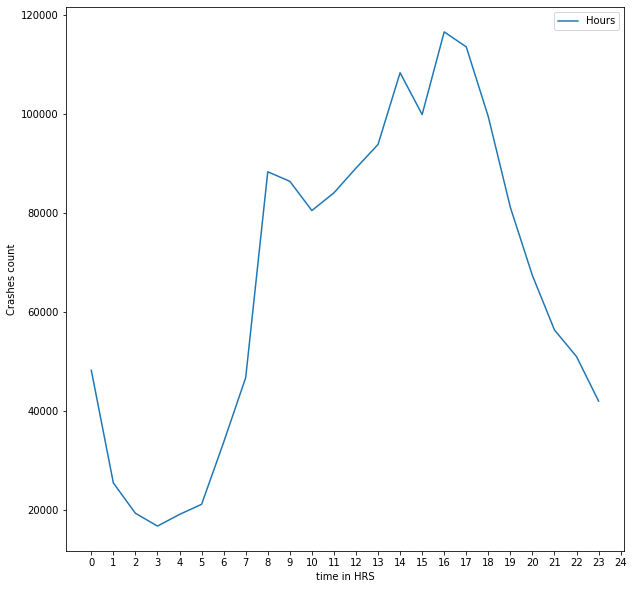

In [23]:
df=pd.DataFrame(data.collect())
df[0] = pd.to_numeric(df[0])
df=df.sort_values(0);
pl=pd.DataFrame({
   'Hours': df[1].tolist(),
   }, index=df[0].tolist())
pl.plot(figsize=(10,10),xticks=range(0,25,1),xlabel="time in HRS",ylabel="Crashes count")

In [34]:
collision_borough=spark.sql("select BOROUGH,count(BOROUGH) as count from col group by BOROUGH having BOROUGH is not null order by count");


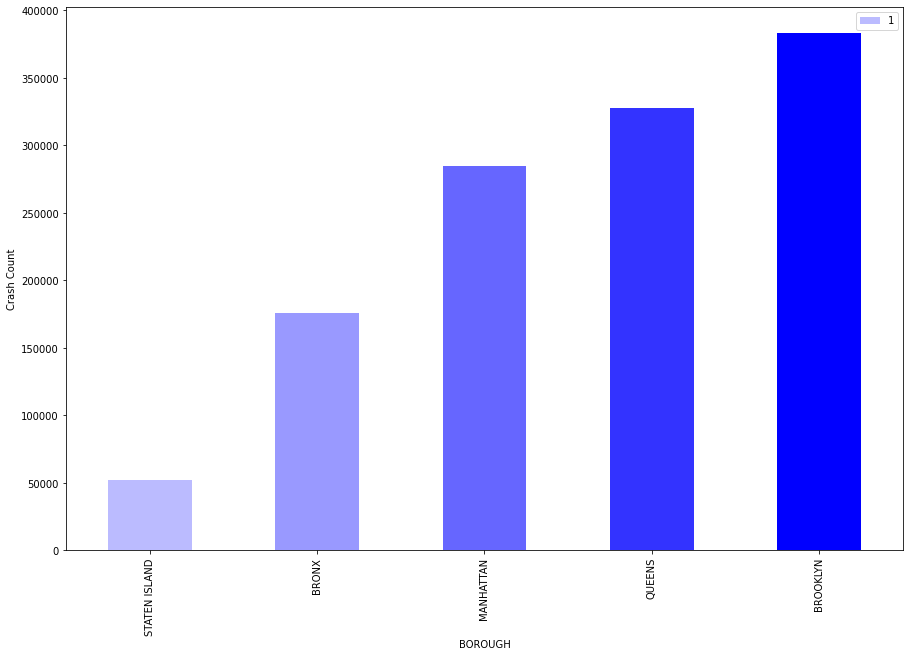

In [38]:
pd.DataFrame(collision_borough.collect()).plot.bar(x=0,y=1,color=["#bbbbff","#9999ff","#6666ff","#3333ff","#0000ff"],figsize=(15,10)
                                                                                                          ,xlabel="BOROUGH",ylabel="Crash Count"      )


In [41]:
collision_by_zip=spark.sql("select `ZIP CODE`,count(`ZIP CODE`) as Accidentcount from col group by `ZIP CODE` having `ZIP CODE` is not null ORDER BY Accidentcount desc limit 5");
collision_by_zip.show();

+--------+-------------+
|ZIP CODE|Accidentcount|
+--------+-------------+
|   11207|        22542|
|   11101|        16714|
|   11236|        15760|
|   10019|        15659|
|   11203|        15364|
+--------+-------------+



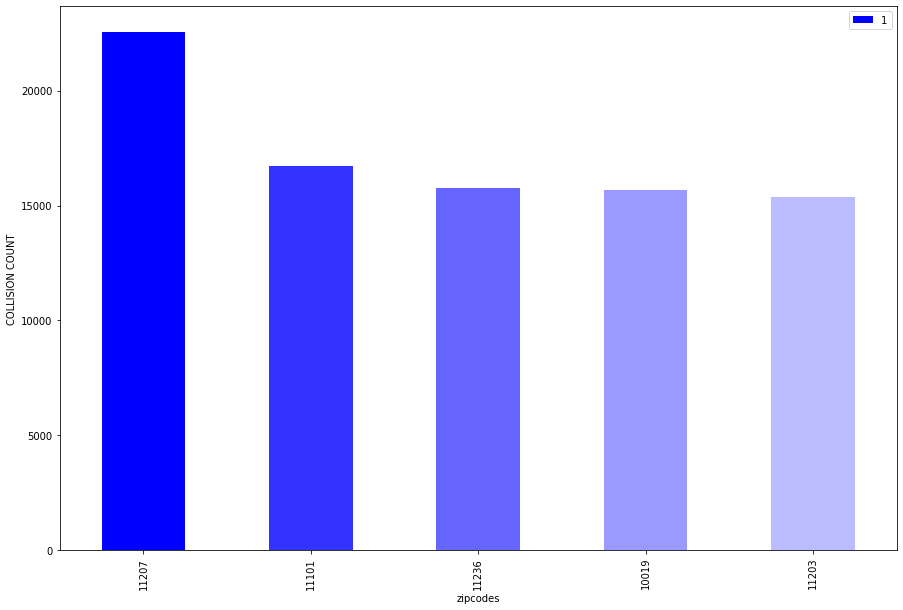

In [43]:
pd.DataFrame(collision_by_zip.collect()).plot.bar(x=0,y=1,color=["#0000ff","#3333ff","#6666ff","#9999ff","#bbbbff"],figsize=(15,10),xlabel="zipcodes",ylabel="COLLISION COUNT");


In [28]:
datayearly=spark.sql("select date_format(`CRASH DATE`,'y') as year, sum(`NUMBER OF PERSONS INJURED`) as injured, sum(`NUMBER OF PERSONS KILLED`) as killed from col group by year order by year");
     

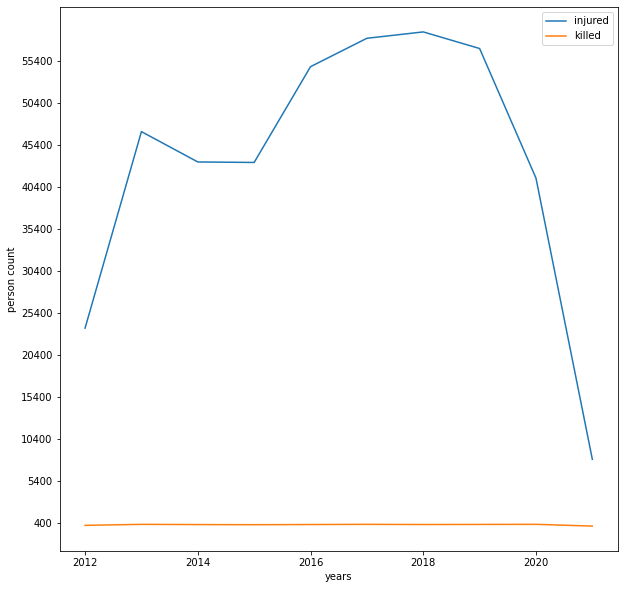

In [29]:
df=pd.DataFrame(datayearly.collect())
df[1]
plo=pd.DataFrame({
   'injured': df[1].tolist(),
   'killed': df[2].tolist()
   }, index=df[0].tolist())
plo.plot(figsize=(10,10),yticks=range(400,60000,5000),xlabel="years",ylabel="person count")

In [30]:
datayearly=spark.sql("select distinct `CRASH DATE` from col ")
     

In [31]:
datayearly.show(10)

+----------+
|CRASH DATE|
+----------+
|2021-01-27|
|2013-03-26|
|2020-08-24|
|2013-01-22|
|2012-10-06|
|2019-06-04|
|2019-05-08|
|2018-08-10|
|2018-05-28|
|2017-09-11|
+----------+
only showing top 10 rows



In [48]:
deadliestMonths=spark.sql("select date_format(`CRASH DATE`,'L') as month,sum(`NUMBER OF PERSONS KILLED`) as killed from col group by month ");
     

*TODO* :Sort by Months

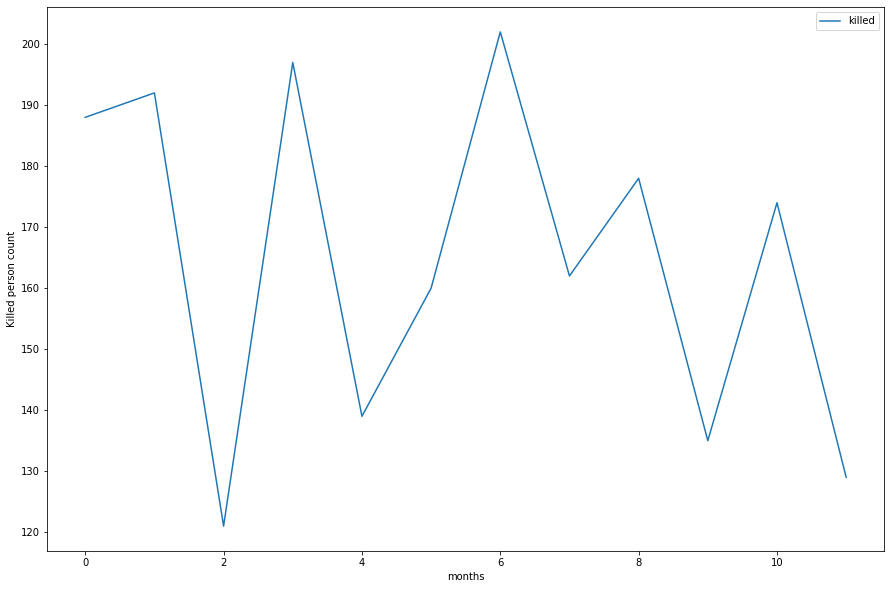

In [50]:
df=pd.DataFrame(deadliestMonths.collect());
plo=pd.DataFrame({
   'killed': df[1].tolist()
   }, index=df[0].tolist().sort() )

plo.plot.line(
    figsize=(15,10),
             xlabel="months",
             ylabel="Killed person count")

In [ ]:
datayearly=spark.sql("select date_format(`CRASH DATE`,'D') as day, sum('COLLISION_ID') as crashcount, as killed from col group by year order by year");
     